In [1]:
#necessary libraries
import librosa
import os
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#import tracks csv file for track_id and genre_top
tracks=pd.read_csv("./fma_metadata/tracks.csv", low_memory=False)

In [ ]:
#all track ids start from index 2
id=tracks['Unnamed: 0'][2:]
id.head()

In [ ]:
#labels for tracks start from index 2
genre=tracks['track.7'][2:]
genre.head()

In [ ]:
#change the track_id name to match fma_small filenames
count=2
for i in id:
    if len(i)==1:
        id[count]='00000'+i+'.mp3'
        count+=1
    elif len(i)==2:
        id[count]='0000'+i+'.mp3'
        count+=1
    elif len(i)==3:
        id[count]='000'+i+'.mp3'
        count+=1
    elif len(i)==4:
        id[count]='00'+i+'.mp3'
        count+=1
    elif len(i)==5:
        id[count]='0'+i+'.mp3'
        count+=1
#check if it worked
id.head()

In [ ]:
#load audio files and extract features
song_feats=[] #will hold feature data
song_genres=[] #will hold label data
path=os.path.abspath(os.path.join("./fma_small/"))
for subfolder in os.listdir(path):
    for filename in os.listdir(os.path.join(path,subfolder)):
        try:
            song, samp_rate=librosa.load(os.path.join(path,subfolder,filename), res_type='kaiser_best')
            #extract mfcc feature from data
            #mfcc = mel-frequency cepstral coefficients
            #mfcc mimics the logarithmic perception of loudness and pitch of human auditory system and tries to eliminate speaker
            #dependent characteristics by excluding the fundamental frequency and their harmonics
            feature=librosa.feature.mfcc(y=song, sr=samp_rate, n_mfcc=80)
            song_feats.append(feature)
            label=genre.loc[id == filename].values.tolist()
            if not label:
                label=genre.loc[id == filename[:6]].values.tolist()
            for key in dict_characters:
                if label[0] == dict_characters[key]:
                    song_genres.append(key)
                    break
                elif not label:
                    song_genres.append(8)
                    break
            #print('Success! Filename=%s with genre=%s' % (filename, label[0]))
        except Exception as e:
            filename='.ipynb_checkpoints'        

In [6]:
#describe genres by label number
dict_characters={0: 'Hip-Hop',1: 'Pop',2: 'Folk',3: 'Rock',4: 'Experimental',5: 'International',6: 'Instrumental',7: 'Electronic'}

In [ ]:
#load the 3D array
song_feats=np.load('song_feats.npy')
song_genres=np.load('song_genres.npy')

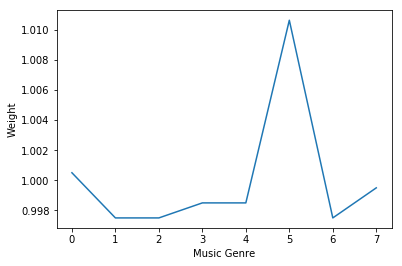

In [25]:
#load class_weights
class_weight=np.load('class_weight3D.npy')

In [34]:
#create training and testing data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(song_feats,song_genres,test_size=0.3)

#check the dimensions
print(x_train.shape)
print(x_test.shape)

In [35]:
#dummy code labels using one hot encoding
from keras.utils.np_utils import to_categorical

y_trainHot=to_categorical(y_train,num_classes=8)
y_testHot=to_categorical(y_test,num_classes=8)

/home/cc/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
#save variables
np.save('x_train3D.npy', x_train)
np.save('x_test3DHalf.npy', x_test)
np.save('y_trainHot3DHalf.npy', y_trainHot)
np.save('y_testHot3DHalf.npy', y_testHot)

In [39]:
#load the variables
x_train=np.load('x_train3DHalf.npy')
x_test=np.load('x_test3DHalf.npy')
y_trainHot=np.load('y_trainHot3DHalf.npy')
y_testHot=np.load('y_testHot3DHalf.npy')

In [41]:
# Helper Functions, Learning Curves, and Confusion Matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pylab as plt

#save all previous epochs for use in plotting Keras Learning Curve
#this is used in function below called plotKerasLearningCurve
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

#Keras Learning Curve function
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    
#Confuson Matrix function
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [42]:
#deep learning libraries
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,Conv1D,MaxPool1D,BatchNormalization
from keras.optimizers import Adam
import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix

In [43]:
#****EDIT THIS FOR TRYING DIFFERENT MODELS****#

#deep learning model
#a = x_train
#b = y_trainHot
#c = x_test
#d = y_testHot
#e = number of epochs
def runCNNmodel(a,b,c,d,e):
    batch=64
    num_labels=8
    one, two = x_train.shape[1], x_train.shape[2]
    input_shape = (one, two)
    #intialize model
    model=Sequential()
    
    #visible layers
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu',input_shape=input_shape))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu',input_shape=input_shape))
    model.add(MaxPool1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu',input_shape=input_shape))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu',input_shape=input_shape))
    model.add(MaxPool1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu',input_shape=input_shape))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu',input_shape=input_shape))
    model.add(MaxPool1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    #8 output nodes
    model.add(Flatten())
    model.add(Dense(512, activation='relu')) #hidden layers
    model.add(Dropout(0.25))
    model.add(Dense(num_labels, activation='softmax'))
    
    #compile the model
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

    #train the model
    model.fit(a,b,batch_size=batch,epochs=e,validation_data=(c,d),callbacks=[MetricsCheckpoint('logs')], class_weight=class_weight3D)
    
    #compute predictions for confusion matrix
    Y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(Y_pred, axis=1),target_names=list(dict_characters.values())), sep='')
    Y_pred_classes = np.argmax(Y_pred,axis = 1)
    Y_true = np.argmax(d,axis = 1)
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    
    #plot confusion matrix
    plot_confusion_matrix(cm=confusion_mtx,classes=list(dict_characters.values()))

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Train on 3990 samples, validate on 3990 samples
Epoch 1/5
3990/3990 [==============================] - 14s 3ms/step - loss: 2.2770 - acc: 0.2190 - val_loss: 1.9681 - val_acc: 0.3168
Epoch 2/5
3990/3990 [==============================] - 10s 3ms/step - loss: 1.9112 - acc: 0.3053 - val_loss: 1.7862 - val_acc: 0.3401
Epoch 3/5
3990/3990 [==============================] - 12s 3ms/step - loss: 1.7787 - acc: 0.3456 - val_loss: 1.6784 - val_acc: 0.3805
Epoch 4/5
3990/3990 [==============================] - 12s 3ms/step - loss: 1.7209 - acc: 0.3744 - val_loss: 1.6885 - val_acc: 0.3957
Epoch 5/5
3990/3990 [==============================] - 10s 3ms/step - loss: 1.6668 - acc: 0.3890 - val_loss: 1.6835 - val_acc: 0.3789

               precision    recall  f1-score   support

      Hip-Hop       0.42      0.32      0.37       494
          Pop       0.24      0.14      0.18       507
         Folk       0.63      0.

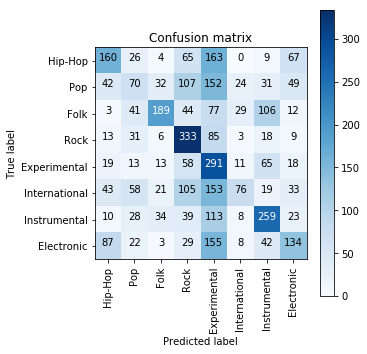

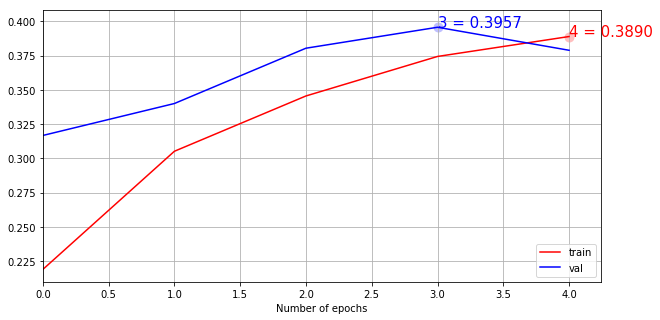

In [44]:
#run the model
runCNNmodel(x_train,y_trainHot,x_test,y_testHot,5)
#plot learning curves across epochs
plotKerasLearningCurve()